In [1]:
import importlib
import utilsHannes as utilsH
import torch

from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper

from nuscenes.eval.prediction.splits import get_prediction_challenge_split

import matplotlib.pyplot as plt
%matplotlib inline



/opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# importlib.reload(utilsH)

# version = "v1.0-mini"
# DATAROOT = "data/sets/nuscenes"
# subset = "mini_train"
# seconds_of_history_used = 2.0
# mini_train = get_prediction_challenge_split('mini_train', dataroot=DATAROOT)
# data_set = mini_train
# sequences_per_instance = "non_overlapping_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance

# # --------------------------------------------------------------------------
# # Use get_and_format_data as a wrapping function:
# img_list, img_tensor_list, agent_state_vector_list, future_xy_local_list = utilsH.get_and_format_data(version, DATAROOT, subset, seconds_of_history_used)

# print(img_tensor_list[0])
# print(agent_state_vector_list[0])
# print(future_xy_local_list[0])



importlib.reload(utilsH)

version = "v1.0-mini" # v1.0-mini, v1.0-trainval
if version == "v1.0-mini":
    train_subset = "mini_train"
    val_subset = "mini_val"
elif version == "v1.0-trainval":
    train_subset = "train"
    val_subset = "val"
     
DATAROOT = "data/sets/nuscenes"
seconds_of_history_used = 2.0 # Half second steps
 

# # Get training data
# img_list1, img_tensor_list1, agent_state_vector_list1, future_xy_local_list1 = utilsH.get_and_format_data(version, DATAROOT, train_subset, seconds_of_history_used, "one_sequences_per_instance")
# img_list2, img_tensor_list2, agent_state_vector_list2, future_xy_local_list2 = utilsH.get_and_format_data(version, DATAROOT, train_subset, seconds_of_history_used, "non_overlapping_sequences_per_instance")
# img_list3, img_tensor_list3, agent_state_vector_list3, future_xy_local_list3 = utilsH.get_and_format_data(version, DATAROOT, train_subset, seconds_of_history_used, "all_sequences_per_instance")

sequences_per_instance = "one_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
img_tensor_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
agent_state_vector_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
future_xy_local_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")

sequences_per_instance = "non_overlapping_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
img_tensor_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
agent_state_vector_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
future_xy_local_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")

sequences_per_instance = "all_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
img_tensor_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
agent_state_vector_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
future_xy_local_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")



length one_sequences_per_instance = 49
length non_overlapping_sequences_per_instance = 110
length all_sequences_per_instance = 557
before squeeze img_tensor.shape = torch.Size([1, 3, 500, 500])
after DS img_tensor.shape = torch.Size([1, 3, 250, 250])
after sqyeeze test_img_tensor.shape = (50, 50, 3)
test_img_tensor[0][0][:] = [255. 255. 255.]
test_img_tensor.astype(int)[0][0][:] = [255 255 255]


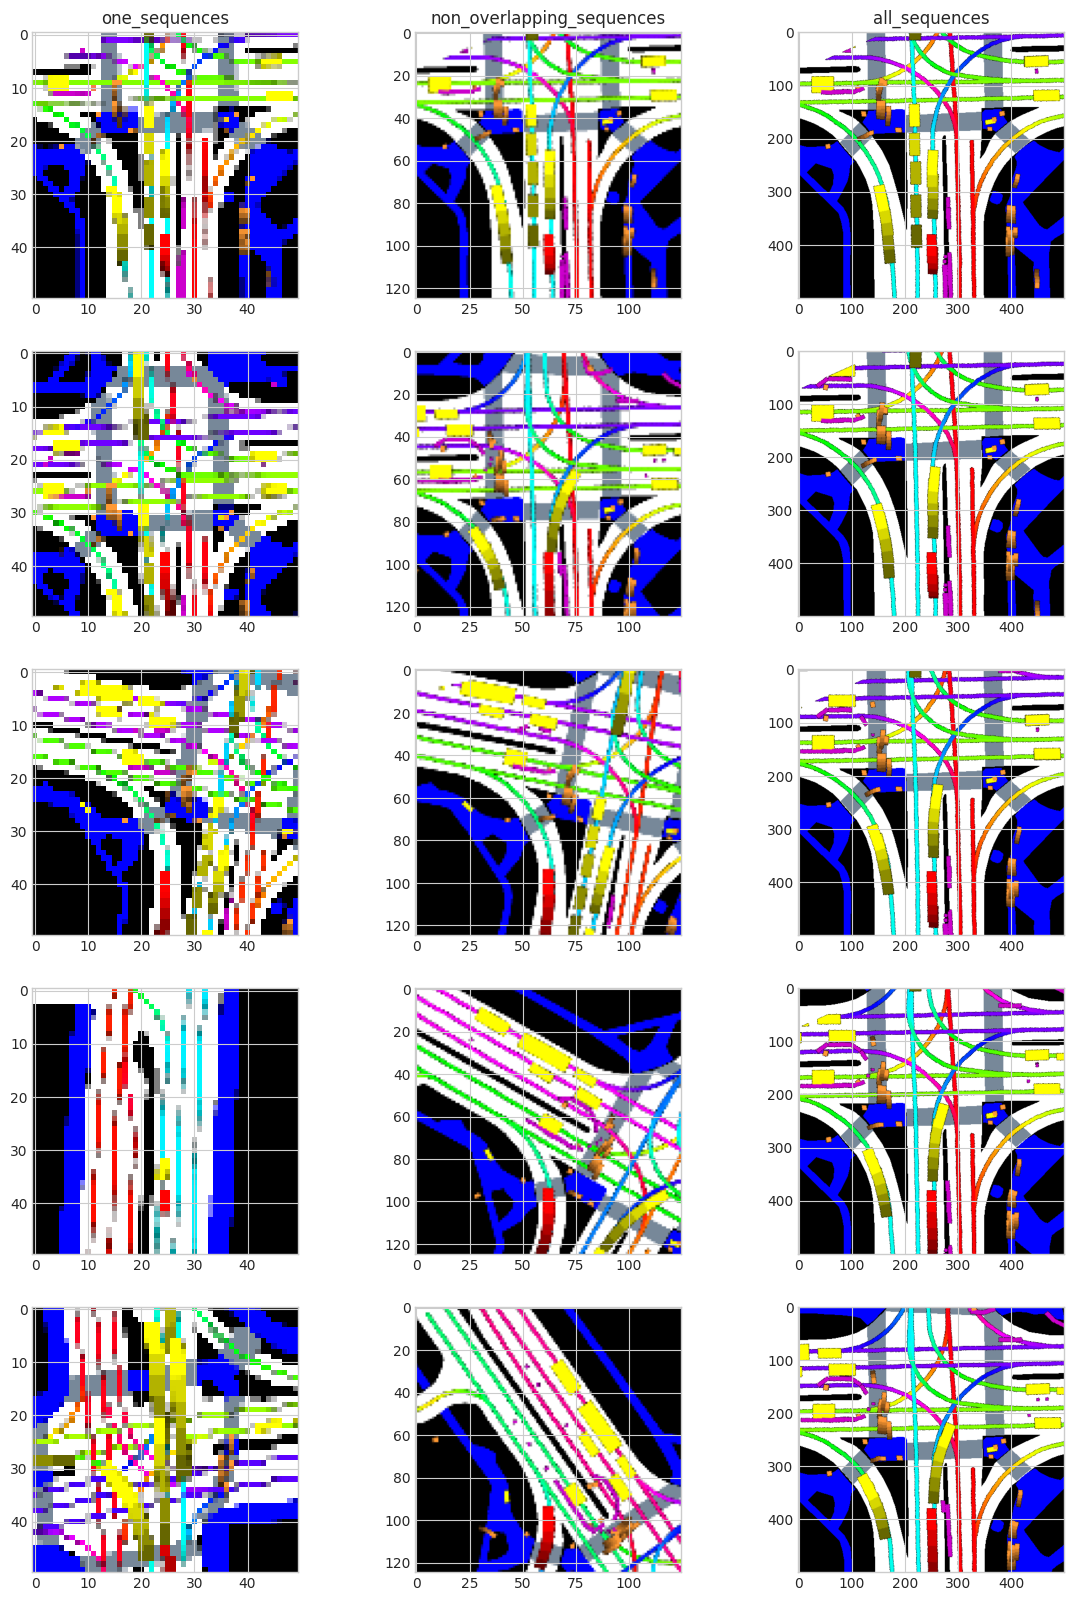

In [3]:
# Test objects for specific index

length = 5
test_index = range(length) #Den ser ut att bryta mellan 108 och 109 exempelvis

print(f"length one_sequences_per_instance = {len(img_tensor_list1)}")
print(f"length non_overlapping_sequences_per_instance = {len(img_tensor_list2)}")
print(f"length all_sequences_per_instance = {len(img_tensor_list3)}")

# test_img_tensor = img_tensor_list1[0].numpy().transpose(1, 2, 0)
print(f"before squeeze img_tensor.shape = {img_tensor_list1[0].shape}")
image_tensor = img_tensor_list1[0]
downsampled_tensor = torch.nn.functional.interpolate(image_tensor, scale_factor=1/2, mode='bilinear')
print(f"after DS img_tensor.shape = {downsampled_tensor.shape}")


# Squeeze for correct dimensions
for i, train_img_tensor in enumerate(img_tensor_list1):
    dummy = torch.nn.functional.interpolate(train_img_tensor, scale_factor=1/10, mode='bilinear')
    img_tensor_list1[i] = torch.squeeze(dummy, dim=0)

for i, train_img_tensor in enumerate(img_tensor_list2):   
    dummy = torch.nn.functional.interpolate(train_img_tensor, scale_factor=1/4, mode='bilinear')
    img_tensor_list2[i] = torch.squeeze(dummy, dim=0)

for i, train_img_tensor in enumerate(img_tensor_list3):
    img_tensor_list3[i] = torch.squeeze(train_img_tensor, dim=0)
    
test_img_tensor = img_tensor_list1[0].numpy().transpose(1, 2, 0)
print(f"after sqyeeze test_img_tensor.shape = {test_img_tensor.shape}")
print(f"test_img_tensor[0][0][:] = {test_img_tensor[0][0][:]}")
print(f"test_img_tensor.astype(int)[0][0][:] = {test_img_tensor.astype(int)[0][0][:]}")


# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(length, 3, figsize=(14, 4*length))

for i in test_index:
#     Plot the first image on the first subplot
    axes[i][0].imshow(img_tensor_list1[i].numpy().transpose(1, 2, 0).astype(int))
    
#     Plot the second image on the second subplot
    axes[i][1].imshow(img_tensor_list2[i].numpy().transpose(1, 2, 0).astype(int))
    
    # Plot the third image on the third subplot
    axes[i][2].imshow(img_tensor_list3[i].numpy().transpose(1, 2, 0).astype(int))
    

    
# # Create a figure with 1 row and 3 columns
# fig, axes = plt.subplots(length, 3, figsize=(14, 4*length))

# # When generated from scratch
# for i in test_index:
# #     Plot the first image on the first subplot
#     axes[i][0].imshow(img_list1[i])
    
# #     Plot the second image on the second subplot
#     axes[i][1].imshow(img_list2[i])
    
#     # Plot the third image on the third subplot
#     axes[i][2].imshow(img_list3[i])
   
   
# Display the plots
axes[0][0].set_title('one_sequences')
axes[0][1].set_title('non_overlapping_sequences')
axes[0][2].set_title('all_sequences')


plt.show()




In [4]:
importlib.reload(utilsH)

## Create video

# output_filename = 'test_output_video_2fps_dt2_50.avi'
output_filename = f'test_output_video_2fps_length_{len(img_list)}.avi'#Daniel
utilsH.create_video(img_list, output_filename, fps=2)

NameError: name 'img_list' is not defined

In [ ]:
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
# from nuscenes.prediction.models.covernet import CoverNet
# from nuscenes.prediction.models.covernet import ConstantLatticeLoss

from utilsHannes import CoverNetNoRelu

import torch

backbone = ResNetBackbone('resnet50')
mtp = MTP(backbone, num_modes=2)

# Note that the value of num_modes depends on the size of the lattice used for CoverNet.
covernet = CoverNetNoRelu(backbone, num_modes=64)

In [ ]:
test_index = 46

covernet.requires_grad_(True)
logits = covernet(img_tensor_list[test_index], agent_state_vector_list[test_index])

sofmaxy = torch.nn.Softmax(dim=1)
outputy = sofmaxy(logits)
print(logits)
print(torch.sum(outputy).item())
print(outputy.detach())

In [ ]:
import pickle

#Epsilon is the amount of coverage in the set, 
#i.e. a real world trajectory is at most 8 meters from a trajectory in this set
#We released the set for epsilon = 2, 4, 8. Consult the paper for more information
#on how this set was created

#PATH_TO_EPSILON_8_SET = "/data/sets/nuscenes-prediction-challenge-trajectory-sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl"
PATH_TO_EPSILON_8_SET = "data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl"
trajectories = pickle.load(open(PATH_TO_EPSILON_8_SET, 'rb'))

#Saved them as a list of lists
trajectories = torch.Tensor(trajectories)

# Hannes kommenterar bort
#Print 5 most likely predictions
# print(trajectories[logits.argsort(descending=True)[:1]])



# Hannes 
newTraj = trajectories[logits.argsort(descending=True)[:1]]
print(newTraj)

In [ ]:
# Hannes cell
import numpy as np

### Choose which trajectory sets to use 
# with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_2.pkl', 'rb') as f:
#     data = pickle.load(f)
# with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_4.pkl', 'rb') as f:
#     data = pickle.load(f)
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    data = pickle.load(f)

allTrajectories = np.array(data)
print(f"Shape of set of all trajectories = {allTrajectories.shape}")

### Plot all trajectories
modes = np.arange(allTrajectories.shape[0])
timesteps = np.arange(12) # 12 timesteps (which is maximum), can be reduced
for mode in modes:
    plt.plot(allTrajectories[mode,timesteps,0],allTrajectories[mode,timesteps,1])
plt.show()


### Plot selected trajectories
numbersOfDisplayedProbabilities = 5
# topPredictedTrajectories = allTrajectories[logits.argsort(descending=True)[0][:numbersOfDisplayedProbabilities]] # Choose top 5 predictions
topPredictedTrajectories = allTrajectories[outputy.argsort(descending=True)[0][:numbersOfDisplayedProbabilities]] # Choose top 5 predictions

# print(allTrajectories)
# print(f"outputy.argsort(descending=True)[0][:numbersOfDisplayedProbabilities] = {outputy.argsort(descending=True)[0][:numbersOfDisplayedProbabilities]}")
# print(topPredictedTrajectories)
# predictedProbabilities = outputy[0][outputy.argsort(descending=True)[0][:5]]

# tmpOutputy = outputy.detach().clone()
# print(tmpOutputy)
# predictedProbabilities = []
# for topPrediction in range(numbersOfDisplayedProbabilities):
#     predictedProbabilitiesIndex = [tmpOutputy.argmax()]
#     print(predictedProbabilitiesIndex)
#     tmpOutputy[0][predictedProbabilitiesIndex] = 0
#     predictedProbabilities.append(predictedProbabilitiesIndex)

## TO GET INDICES
outputyValues = outputy.detach().numpy().squeeze()
predictedProbabilitiesIndices = np.argsort(outputyValues)
predictedProbabilities = outputyValues[predictedProbabilitiesIndices]
# topProbabilitiesIndices = predictedProbabilities[0][::-1][0:numbersOfDisplayedProbabilities]
topProbabilitiesIndices = predictedProbabilitiesIndices[::-1][0:numbersOfDisplayedProbabilities]
# predictedProbabilities = outputy.argsort(descending=True)
# topProbabilities = predictedProbabilities[0][0:5]
# topProbabilities = topProbabilitiesIndices

# print(outputyValues)
## TO GET VALUES 
topProbabilities = []
for index in topProbabilitiesIndices:
    topProbabilities.append(outputyValues[index])


# print(f"outputy = {outputy}")
print(f"predictedProbabilities = {predictedProbabilities}")
print(f"predictedProbabilitiesIndices = {predictedProbabilitiesIndices}")
print(f"topProbabilitiesIndices = {topProbabilitiesIndices}")
print(f"topProbabilities = {topProbabilities}")
print(f"Shape of top predicted trajectories = {topPredictedTrajectories.shape}")
modes2 = np.arange(topPredictedTrajectories.shape[0])
# timesteps = np.arange(12)
for mode in modes2:
    plt.plot(allTrajectories[mode,timesteps,0],allTrajectories[mode,timesteps,1])
plt.ylim([-10,120])
plt.xlim([-40,40])
# plt.legend(["1th prediction", "2nd prediction", "3rd prediction", "4th prediction", "5th prediction"])
plt.legend(topProbabilities)
plt.show()


# Test line for pushing, again


In [ ]:
# GPT with covernet input

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
# from nuscenes.prediction.models.covernet import CoverNet

importlib.reload(utilsH)
from utilsHannes import CoverNetNoRelu
from nuscenes.prediction.models.covernet import ConstantLatticeLoss
from nuscenes.prediction.models.covernet import mean_pointwise_l2_distance


version = "v1.0-trainval" # v1.0-mini, v1.0-trainval
DATAROOT = "data/sets/nuscenes"
subset = "train" #One of 'mini_train', 'mini_val', 'train', 'val'.
seconds_of_history_used = 2.0

# --------------------------------------------------------------------------
# Use get_and_format_data as a wrapping function:
img_list, img_tensor_list, agent_state_vector_list, future_xy_local_list = utilsH.get_and_format_data(version, DATAROOT, subset, seconds_of_history_used)

#################################################################################################################################
# Define your custom dataset class that inherits from torch.utils.data.Dataset
class NuscenesDataset(Dataset):
    def __init__(self, image_data, agent_state_data, ground_truth_data):
        self.image_data = image_data
        self.agent_state_data = agent_state_data
        self.ground_truth_data = ground_truth_data
        
    def __len__(self):
        return len(self.image_data)
    
    def __getitem__(self, index):
        image_data_item = self.image_data[index]
        agent_state_data_item = self.agent_state_data[index]
        ground_truth_data_item = self.ground_truth_data[index]
        
        return image_data_item, agent_state_data_item, ground_truth_data_item

#################################################################################################################################


In [ ]:
# Prints
num_datapoints = len(img_tensor_list)
print(f"num_datapoints = {num_datapoints}")
print(f"img_tensor_list = {img_tensor_list[0].size()}")
print(f"agent_state_vector_list = {agent_state_vector_list[0]}")
print(f"future_xy_local_list = {future_xy_local_list[0][0]}")

# For testing
short_size = 100
short_img_tensor_list = img_tensor_list[:short_size]
short_agent_state_vector_list = agent_state_vector_list[:short_size]
short_future_xy_local_list = future_xy_local_list[:short_size]

# Prints
num_datapoints = len(short_img_tensor_list)
print(f"short_num_datapoints = {num_datapoints}")

# Define your dataset
dataset = NuscenesDataset(img_tensor_list, agent_state_vector_list, future_xy_local_list)
shortDataset = NuscenesDataset(short_img_tensor_list, short_agent_state_vector_list, short_future_xy_local_list)

# Instantiate your dataloader
batch_size = 10 # 32
shuffle = True # Set to True if you want to shuffle the data
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
shortDataloader = DataLoader(shortDataset, batch_size=batch_size, shuffle=shuffle)

# Initialize the CoverNet model
backbone = ResNetBackbone('resnet50') 
num_modes = 64 # 2206, 415, 64
covernet = CoverNetNoRelu(backbone, num_modes)



# Lattice and similarity function
traj_epsilon = 8
with open(f'data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_{traj_epsilon}.pkl', 'rb') as f:
    latticeData = pickle.load(f)
lattice = np.array(latticeData) # a numpy array of shape [num_modes, n_timesteps, state_dim]
print(f"latticeSize = {len(lattice[0])}")
similarity_function = mean_pointwise_l2_distance  # You can also define your own similarity function

# Define your loss function and optimizer
loss_function = ConstantLatticeLoss(lattice, similarity_function)
lr = 1e-4 # From Covernet paper: fixed learning rate of 1e−4
optimizer = optim.Adam(covernet.parameters(), lr=lr)  # Replace <YOUR_LEARNING_RATE> with your desired learning rate

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
covernet.to(device)

# Training loop
num_epochs = 100  # Replace <YOUR_NUM_EPOCHS> with the number of epochs you want to train for
for epoch in range(num_epochs):
    epochLoss = 0
    for batchCount, batch in enumerate(shortDataloader):

        # Get batch data
        image_tensor, agent_state_vector, ground_truth_trajectory = batch
        image_tensor = image_tensor.to(device)
        agent_state_vector = agent_state_vector.to(device)
        ground_truth_trajectory = ground_truth_trajectory.to(device)

        # print(f"image_tensor before squeeze = {image_tensor.size()}")
        image_tensor = torch.squeeze(image_tensor, dim=1)
        # print(f"image_tensor after squeeze = {image_tensor.size()}")

        # print(f"agent_state_vector before squeeze = {agent_state_vector.size()}")
        agent_state_vector = torch.squeeze(agent_state_vector, dim=1)
        # print(f"agent_state_vector after squeeze = {agent_state_vector.size()}")
        
        # print(f"ground_truth_trajectory before squeeze = {ground_truth_trajectory.size()}")
        # ground_truth_trajectory = torch.squeeze(ground_truth_trajectory, dim=1)
        # print(f"ground_truth_trajectory after squeeze = {ground_truth_trajectory.size()}")


        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = covernet(image_tensor, agent_state_vector)

        # Compute loss
        loss = loss_function(logits, ground_truth_trajectory)

        # Backward pass
        loss.backward()
        optimizer.step()
        epochLoss += loss.item()



        # Print loss for this batch
        # print(f"Batch [{batchCount+1}/{int(num_datapoints/batch_size)+1}], Batch Loss: {loss.item():.4f}")
     
    # Print loss for this batch
    print(f"Epoch [{epoch+1}/{num_epochs}], Epoch Loss: {epochLoss:.4f}")


    # Optionally, you can evaluate the model after each epoch
    # by running inference on a validation set and computing relevant metrics

# Training complete
print("Training complete!")


In [ ]:
# Forward pass
logits = covernet(image_tensor, agent_state_vector)
logits

In [ ]:
# Test utilsHannes.py functions

import importlib
import utilsHannes as utilsH
importlib.reload(utilsH)

try:
    utilsH.test_utilsH_functions()
    print("All tests passed!")
except AssertionError as e:
    print(f"Error: {e}")